In [2]:
from tensorflow.keras.layers import Dense, Flatten, Dropout,Input
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,MaxPooling2D,AveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam,schedules
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, History
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import random
import numpy as np
import os,cv2
import matplotlib
import load_image
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import io
imgH = 32
imgW = 32
TRAIN_SPLIT = 0.85
DIR = "./"

In [3]:
def prepare_image_array(imgDir, imgW, imgH):
    imgList = os.listdir(imgDir)
    # print(imgList)
    n = len(imgList)

    imgSet = []
    for i in range(n):
        imgPath = imgDir + imgList[i]
        if (os.path.exists(imgPath)):
            # print(imgPath)
            img = cv2.imread(imgPath)
            resizedImg = cv2.resize(img, (imgW, imgH))
            rgbImg = cv2.cvtColor(resizedImg, cv2.COLOR_BGR2RGB)
            imgSet.append(rgbImg)
        else:
            print("It is not a valid image path.")

    # print("total image "+str(len(imgSet)))
    imgSet = np.array(imgSet, dtype=np.uint8)
    # print("total shape "+str(imgSet.shape))

    return imgSet


In [4]:
imgDir = DIR + 'Normal/'
imgSet1 = prepare_image_array(imgDir, imgW, imgH)
m = imgSet1.shape[0]

imgDir = DIR + 'OverExposed/'
imgSet2 = prepare_image_array(imgDir, imgW, imgH)
n = imgSet2.shape[0]

imgDir = DIR + 'UnderExposed/'
imgSet3 = prepare_image_array(imgDir, imgW, imgH)
o = imgSet3.shape[0]

# Put all image data into one array.
imgSet = np.concatenate((imgSet1, imgSet2, imgSet3), axis=0)
print(imgSet.shape)

labelSet1 = np.zeros(m, dtype=np.uint8)
labelSet2 = np.ones(n, dtype=np.uint8)
label_o = np.ones(o, dtype=np.uint8)
labelSet3 = np.add(label_o, label_o)
labelSet = np.concatenate((labelSet1, labelSet2, labelSet3), axis=0)


p = imgSet.shape[0]  # p = n + m + o
# indices = np.array(file.read())
# indices = np.arange(p)
# random.shuffle(indices)
# for i in range(len(indices)):
#     file.write(str(indices[i])+",")

# file.close()
f = open('data_index.txt', 'r')
indices = []
for x in f.read().split(','):
    if len(x) > 0:
        num = ''
        for j in x:
            if(j>='0' and j<='9'):
                num +=j;
        if len(num)>0 and int(num)<p:
            indices.append(int(num)) 

# print(indices)
imgSet = imgSet[indices]
labelSet = labelSet[indices]
print(labelSet[:5])
print("Label set : ")
labelSet = labelSet.reshape(p, 1)

#   one hot encoding

labelSet = to_categorical(labelSet)

# print(labelSet[:5])

# print(imgSet[0])
imgSet = imgSet.astype(np.float32)
imgSet = imgSet/255.0

r = int(p * TRAIN_SPLIT)
trainX = imgSet[:r]
trainY = labelSet[:r]
testX = imgSet[r:]
testY = labelSet[r:]



(8984, 32, 32, 3)
[0 2 1 2 0]
Label set : 


In [38]:

DIR = './Fully-Connnected-model/'
modelpath = DIR + 'Fully_connected_Classifier.hdf5'
file = open(DIR+'Fully_connected.txt',"w")


In [39]:


inputs = Input(shape=(imgH, imgW, 3))
x = Flatten()(inputs)
x = Dense(units=1024, activation="relu")(x)
x = Dense(units=512, activation="relu")(x)
# x = Dense(units=512, activation="relu")(x)
# x = Dropout(.15)(x)
x = Dense(units=256, activation="relu")(x)
# x = Dense(units=256, activation="relu")(x)
x = Dropout(.3)(x)
# x = Dense(units=128, activation="relu")(x)
# x = Dense(units=128, activation="relu")(x)
x = Dense(units=128, activation="relu")(x)
# x = Dense(units=64, activation="relu")(x)
# x = Dense(units=64, activation="relu")(x)
x = Dense(units=64, activation="relu")(x)
x = Dense(units=32, activation="relu")(x)
# x = Dropout(.15)(x)

x = Dense(units=8, activation="relu")(x)
# x = Dense(units=8, activation="relu")(x)
# x = Dense(units=8, activation="relu")(x)
outputs = Dense(units=3, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()
# model.compile(optimizer="rmsprop",loss='mse',metrics  = ['accuracy'])



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_24 (Dense)            (None, 1024)              12583936  
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               3289

In [40]:


import tensorflow as tf
output = []
history_dic = []
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=10000,
    decay_rate=0.9)



  # callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

sgd = SGD(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
callbackList = [EarlyStopping(monitor='val_loss', patience=50), History()]
history = model.fit(trainX, trainY, epochs=100, batch_size=128, validation_split=0.2, callbacks=callbackList)
model.save(modelpath)

loss, accuracy = model.evaluate(testX, testY)
print('Accuracy: {}'.format(accuracy))

Epoch 1/100
48/48 [==============================] - 6s 95ms/step - loss: 1.0324 - accuracy: 0.3397 - val_loss: 0.9906 - val_accuracy: 0.4208
Epoch 2/100
48/48 [==============================] - 4s 84ms/step - loss: 0.9922 - accuracy: 0.4041 - val_loss: 0.9479 - val_accuracy: 0.4548
Epoch 3/100
48/48 [==============================] - 4s 86ms/step - loss: 0.9640 - accuracy: 0.4633 - val_loss: 0.9210 - val_accuracy: 0.4863
Epoch 4/100
48/48 [==============================] - 4s 82ms/step - loss: 0.9379 - accuracy: 0.5100 - val_loss: 0.8989 - val_accuracy: 0.5327
Epoch 5/100
48/48 [==============================] - 4s 85ms/step - loss: 0.9184 - accuracy: 0.5396 - val_loss: 0.8788 - val_accuracy: 0.5674
Epoch 6/100
48/48 [==============================] - 4s 81ms/step - loss: 0.8958 - accuracy: 0.5624 - val_loss: 0.8606 - val_accuracy: 0.6073
Epoch 7/100
48/48 [==============================] - 4s 85ms/step - loss: 0.8753 - accuracy: 0.5891 - val_loss: 0.8393 - val_accuracy: 0.5942
Epoch 

In [44]:
loss, accuracy = model.evaluate(testX, testY)
print('Accuracy: {}'.format(accuracy))

43/43 [==============================] - 0s 8ms/step - loss: 0.5775 - accuracy: 0.7774
Accuracy: 0.7774480581283569


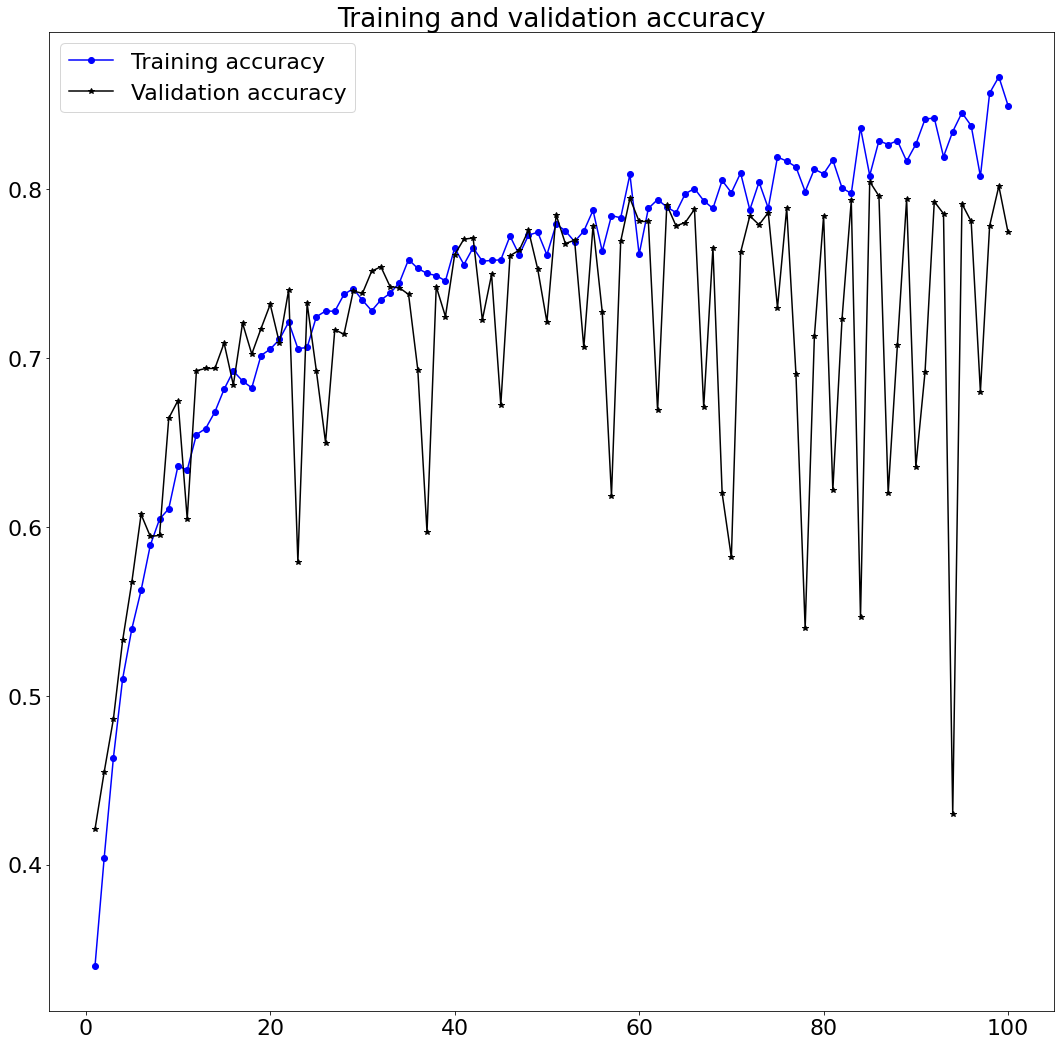

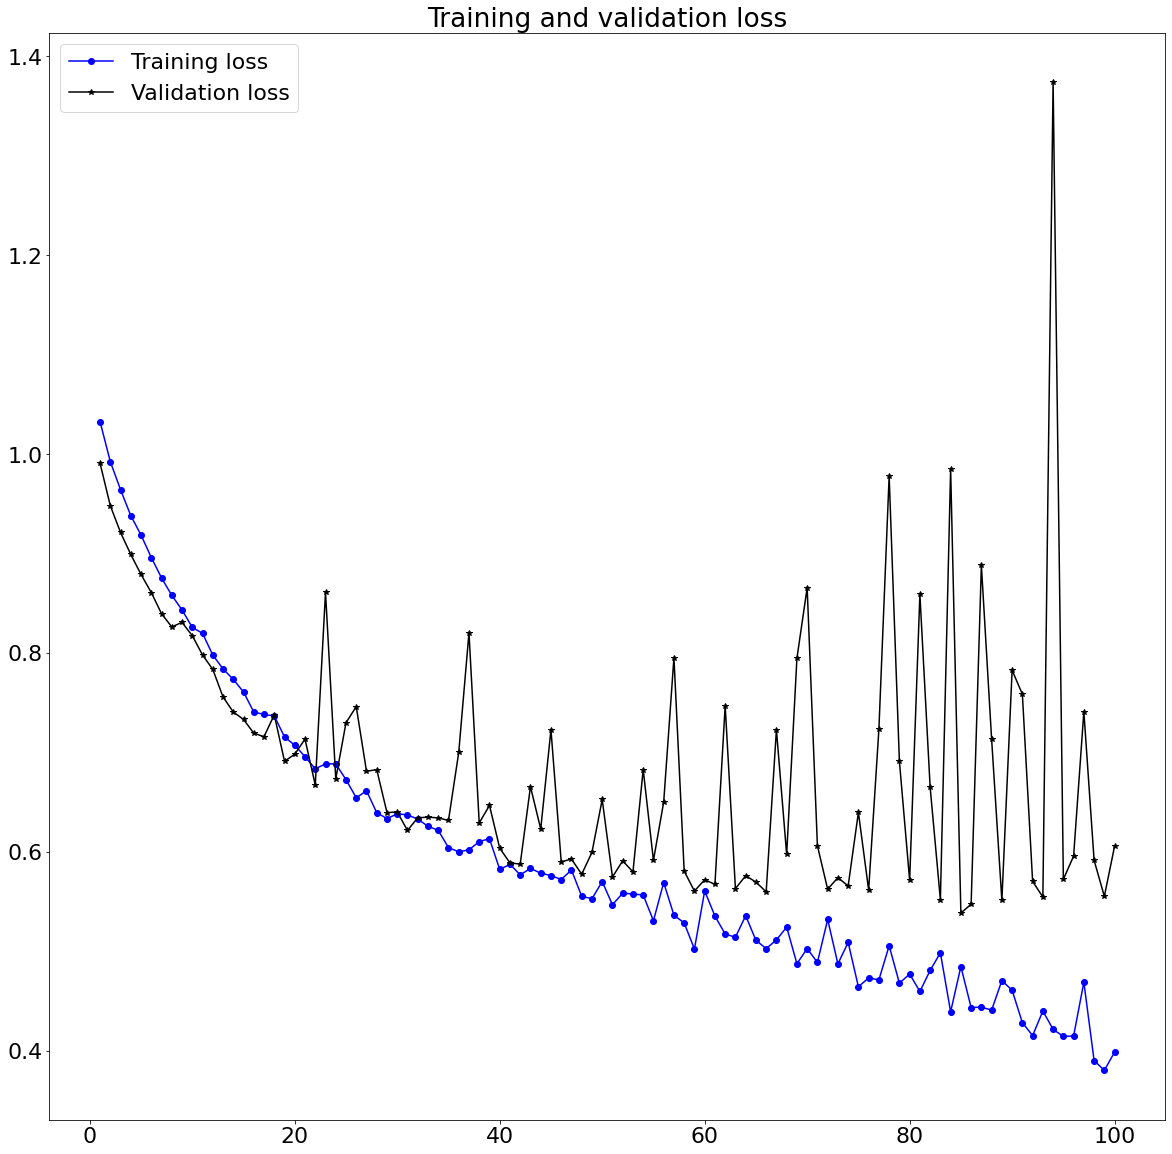

In [45]:
def plot_loss_acc(history):
    accuracy = history.history['accuracy']
    valaccuracy = history.history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)
    plt.figure(figsize=(18, 18))
    plt.rcParams['font.size'] = '22'
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, valaccuracy, 'k*-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig(DIR + 'Large_CNN_training_validation_accuracy.png')
    plt.show()
    plt.close()
    
    loss = history.history['loss']
    valLoss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(20, 20))
    plt.rcParams['font.size'] = '22'
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, valLoss, 'k*-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    plt.savefig(DIR + 'Large_CNN_training_validation_loss.png')
    plt.close()
    
plot_loss_acc(history)